In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from fastai import *
from fastai.vision import *
from fastai.callbacks import *
from pathlib import Path

train = pd.read_csv ('data/titanic_train_wrangled.csv')
test = pd.read_csv ('data/titanic_test_wrangled.csv')

In [2]:
# remove unused columns
exclude = ['passengerid']
feature_candidates = train.drop (columns=exclude).drop (columns=['survived'])
feature_names = list (feature_candidates.columns)

In [5]:
"""
    Convert features to square PNG
"""
def convert_df_to_images (df, target=[], training=True, spread=1):
    import math
    import os
    import glob
    from PIL import Image

    # create images folder if it doesn't exist
    if not os.path.exists ('images_titanic'):
        path = os.makedirs('images_titanic')
    else:
        # clean out directory folder
        files = glob.glob('images_titanic/*.*', recursive=True)
        for f in files:
            os.remove(f)

    # first determine square image size to accommodate features
    sqrt = (df.shape[1])**(0.5)
    sqrval = math.ceil(sqrt) * spread # round up to next int and spread pixels
    for i, row in df.iterrows():
        img = Image.new ('RGB', (sqrval,sqrval), color='black')
        cols = df.shape[1]
        cnt = 0
        for x in range(0, sqrval, spread):
            for y in range(0, sqrval, spread):
                if cnt < cols:
                    if row[cnt] == 0:
                        img.putpixel( (x,y), (0,0,0) )
                    else:
                        img.putpixel( (x,y), (255,255,255) )
                else:
                    # fill in the remaining pixels
                    img.putpixel( (x,y), (0,0,0) )
                cnt += 1
        # write out image file for this row
        if training:
            if target[i] == 0:
                filename = 'images_titanic/' + 'died_' + str(i) + '.png'
            else:
                filename = 'images_titanic/' + 'survived_' + str(i) + '.png'
        else:
            filename = 'images_titanic/' + str(i) + '.png'
        img.save (filename)

In [6]:
convert_df_to_images (train_x, train_y, spread=1)

In [7]:
path_img = Path('images_titanic')
fnames = get_image_files (path_img)
np.random.seed(2)
re_pat = r'/([^/]+)_\d+.png'
data = ImageDataBunch.from_name_re(path_img, fnames, re_pat, ds_tfms=get_transforms(), size=224, bs=64)
n = data.normalize(imagenet_stats)

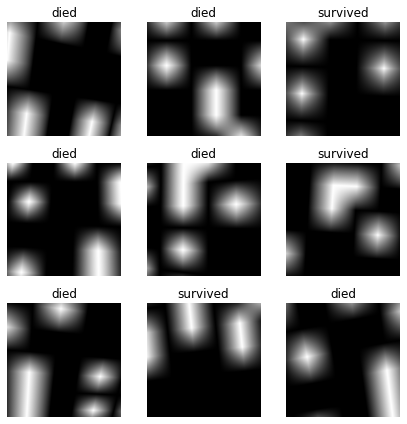

In [8]:
data.show_batch(rows=3, figsize=(6, 6))

In [9]:
data.classes

['died', 'survived']

In [10]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate, callback_fns=[CSVLogger])

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/thomas/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [11]:
learn.fit_one_cycle (4)
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,error_rate,time
0,0,1.115907,1.413522,0.595506,00:05
1,1,1.083075,1.482923,0.522472,00:03
2,2,1.026399,0.786349,0.286517,00:03
3,3,0.948486,0.826102,0.325843,00:03


In [12]:
learn.unfreeze()
learn.fit_one_cycle (4)
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,error_rate,time
0,0,0.801584,0.925066,0.337079,00:05
1,1,0.822408,1.066636,0.331461,00:04
2,2,0.748215,0.619292,0.230337,00:04
3,3,0.683883,0.586560,0.224719,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


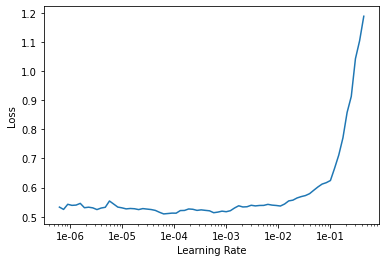

In [13]:
learn.lr_find()
learn.recorder.plot()

In [14]:
learn.unfreeze()
learn.fit_one_cycle(4, max_lr=slice(1e-45, 1e-40))
learn.csv_logger.read_logged_file()

,epoch,train_loss,valid_loss,error_rate,time
0,0,0.530046,0.561382,0.230337,00:04
1,1,0.513332,0.552652,0.224719,00:04
2,2,0.519582,0.551190,0.219101,00:04
3,3,0.522717,0.551633,0.219101,00:05


In [15]:
learn.save ('stage-1')

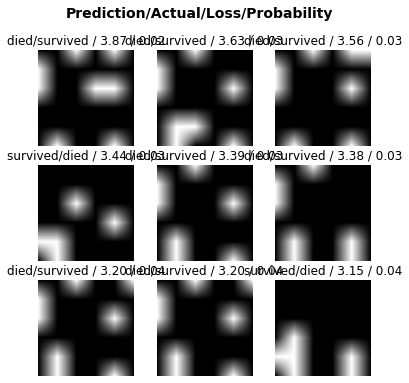

In [16]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(6,6))

In [17]:
# Generate predictions
learn.load('stage-1')
test['survived'] = 0
convert_df_to_images (test_x, training=False, spread=1)
for i, row in test_x.iterrows():
    filename = 'images_titanic/' + str(i) + '.png' 
    img = open_image(filename)
    pred_class, pred_idx, outputs = learn.predict(img)
    if str(pred_class) == 'survived':
        test.at[i, 'survived'] = 1

In [18]:
# Create the Kaggle submission file
kg_df = pd.DataFrame()
kg_df['PassengerId'] = test['passengerid']
kg_df['Survived'] = test['survived'].astype(int)
kg_df.to_csv ('data/submission.csv', index=False)